In [1]:
%matplotlib notebook

import os
import re
import fnmatch
import numpy as np

from sklearn.model_selection import train_test_split
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
plt.ioff()

from python_speech_features import mfcc

In [2]:
# Define constants
DATA_ROOT = 'data'
TRAIN_TEST_SPLIT_PCT = 0.3
RANDOM_STATE = 12345
DELTA_PAD_IN_SEC = 0.05
DELTA_PARAM = 2

In [3]:
# Get all files
root = os.path.abspath(DATA_ROOT)
data_files = os.listdir(root)

# Get unique labels; discard device info
pattern = '[0-9]+_(.*).txt'
dataset = list()
for data_file in data_files:
    if re.match(pattern, data_file):
        dataset.append({
            'label': data_file
        })
    
# Append data files to list of dict
for counter, data in enumerate(dataset):
    label = data['label'].split('.txt')[0]
    matching_data = fnmatch.filter(data_files, label + '*.wav')
    dataset[counter]['signal'] = matching_data[0]

# Perform train/test split
dataset_train, dataset_test = train_test_split(dataset, test_size=TRAIN_TEST_SPLIT_PCT, random_state=RANDOM_STATE)

# Print top of the list
dataset_train[:5]

[{'label': '258135_24_M_20_2.txt', 'signal': '258135_24_M_20_2.wav'},
 {'label': '258135_24_M_21_3.txt', 'signal': '258135_24_M_21_3.wav'}]

In [4]:
# Temporarily take a single data-label pair
data = dataset_train[0]

<IPython.core.display.Javascript object>


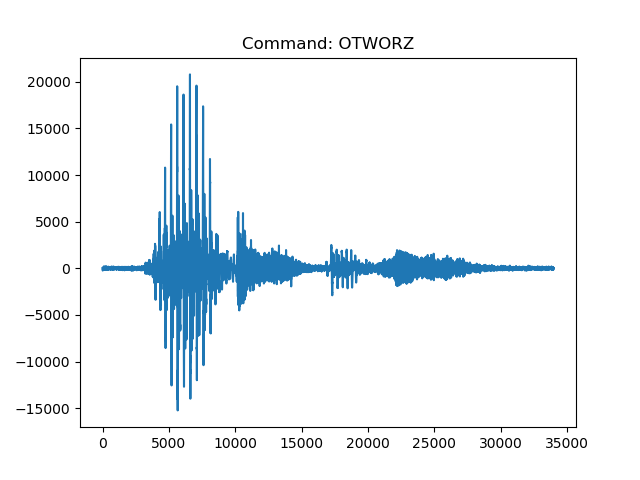

In [5]:
# Read samples
temp_path = os.path.join(root, data['signal'])
srate, samples = wav.read(temp_path)

# Create time vector
time = np.linspace(0, (len(samples)-1)/srate, len(samples))

# Parse command labels
temp_path = os.path.join(root, data['label'])
pause = list()
with open(temp_path) as f:
    labels = [line.split('\t') for line in f]
    for label in labels:
        label[0] = float(label[0])
        label[1] = float(label[1])
        label[2] = label[2].split('\n')[0]
        
        # Build pause segments from signal portions between commands
        if len(pause):
            pause[-1][1] = label[0]
        pause.append([
            label[1],
            0,
            '-'
        ])
        
# Remove last element and append to labels
pause.pop()
labels += pause

# Assign signal segments to each command
segments = list()
targets = list()
for label in labels:
    targets.append(label[2])
    segments.append(
        samples[(time >= label[0] - DELTA_PAD_IN_SEC) & (time <= label[1] + DELTA_PAD_IN_SEC)]
    )

# Display an exemplary time series
plt.plot(segments[0])
plt.title('Command: ' + targets[0])
plt.show()

Chosen features: MFCC<br>
<hr>
References:<br>
<ul>
    <li>http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html</li>
<li>http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/</li>
    </ul>

<IPython.core.display.Javascript object>


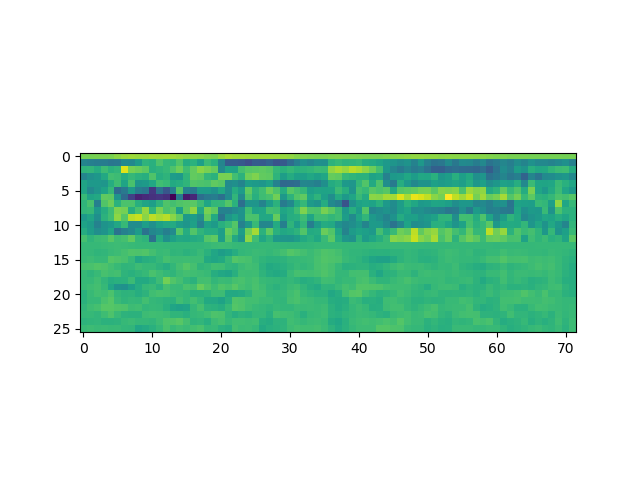

In [6]:
# Calculate MFCC features for a single command signal segment
segment = segments[0]
mfcc_features = mfcc(segment, srate, winfunc=np.hamming)
mfcc_features = np.asarray(mfcc_features)

# Calculate MFCC deltas
d_numerator = list()
d_denominator = list()
for n in range(1, DELTA_PARAM + 1):
    result = n * (mfcc_features[2*n:] - mfcc_features[:-2*n])
    if len(d_numerator) == 0:
        d_numerator = result
        d_denominator = 2 * (n ** 2)
    else:
        d_numerator = d_numerator[1:-1] + result
        d_denominator += 2 * (n ** 2)
delta_features = d_numerator / d_denominator

# Merge MFCC and deltas
features = np.concatenate((mfcc_features[DELTA_PARAM:-DELTA_PARAM], delta_features), axis=1)

# Display an exemplary MFCC image
plt.imshow(features.T)
plt.show()